In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize as nrm 

%matplotlib inline

In [2]:
import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "F:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True

In [3]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = os.path.join(data_root, data_dirname)

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=use_static)

In [4]:
ecephys_sessions_table = cache.get_ecephys_session_table()

sst_novel_sessions = ecephys_sessions_table[(ecephys_sessions_table['genotype'].str.contains('Sst')) & 
                                            (ecephys_sessions_table['experience_level']=='Novel')]
sst_novel_sessions.head(1)

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1053941483,1053960987,2020-10-01 17:03:58.362,NP.1,EPHYS_1_images_H_3uL_reward,527749,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,180,1543.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,6,NaN,NaN


C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


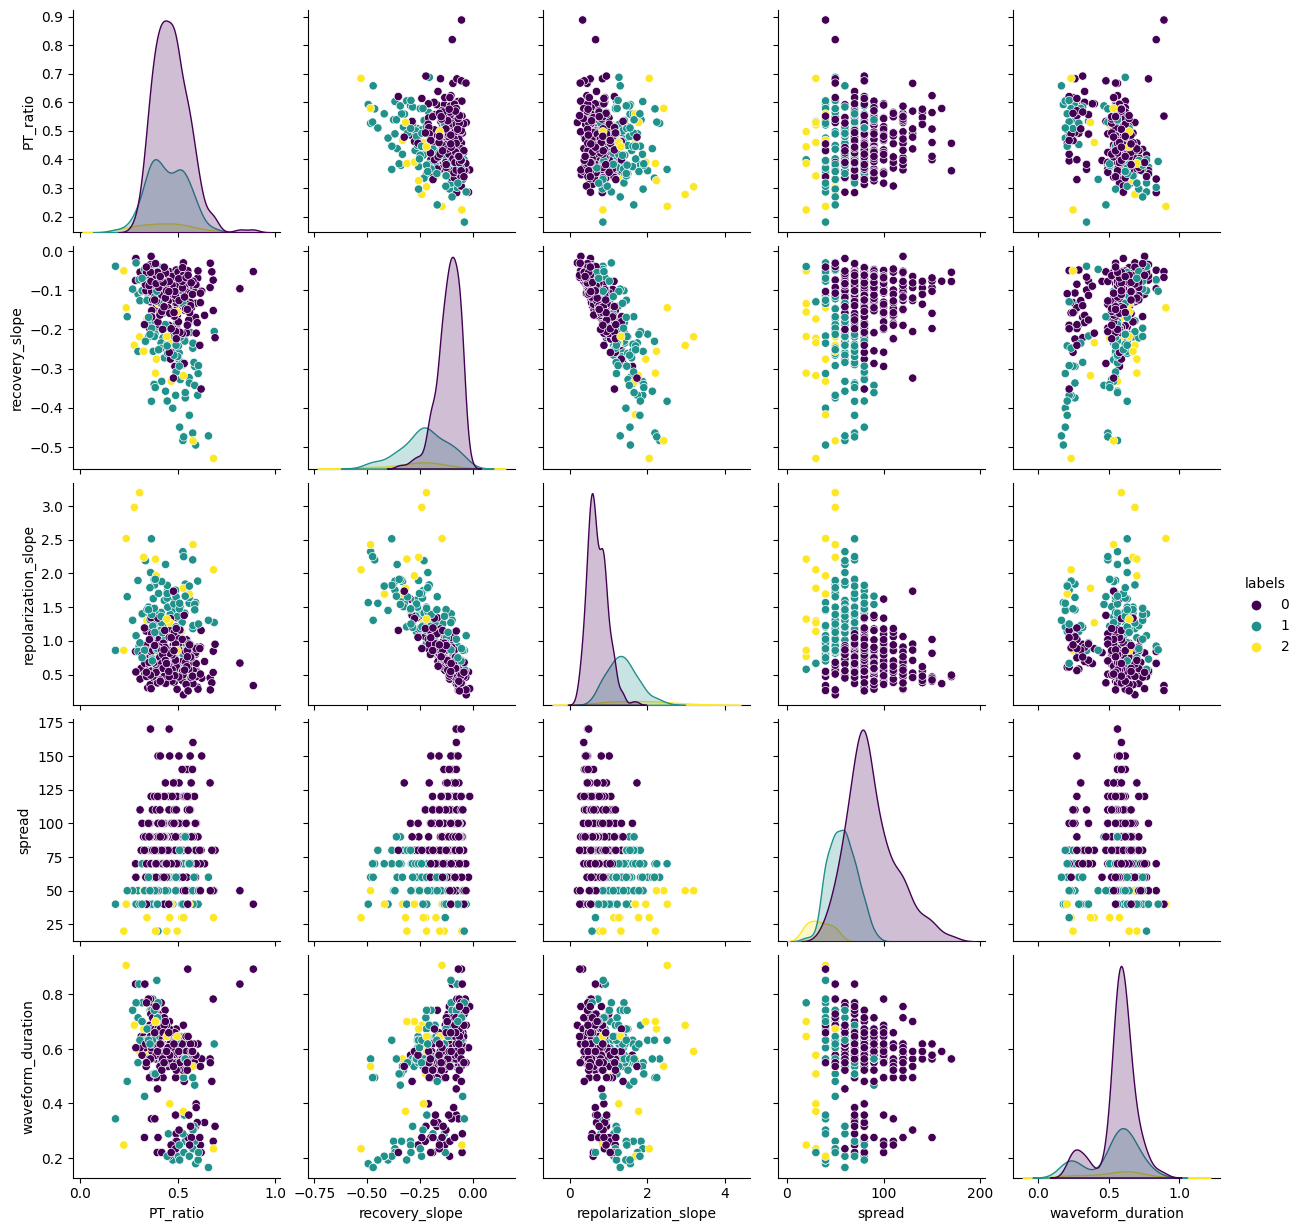

In [6]:
def plotUpVICellWaveformProperties(session_id):
    session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
    stimulus_presentations = session.stimulus_presentations
    units = session.get_units()
    channels = session.get_channels()
    units = units.merge(channels, left_on='peak_channel_id', right_index=True)
    good_V1_units = units[(units['structure_acronym'].str.contains('VI')) & 
                      (units['quality'] == 'good') & 
                      (units['isi_violations'] < 1) & 
                      (units['snr'] > 1)
                     ]
    features_to_study = good_V1_units[['PT_ratio', 'recovery_slope', 'repolarization_slope', 'spread', 'waveform_duration']]
    features_to_study = features_to_study[features_to_study['PT_ratio']<1]
    features_to_study.dropna()
    features = features_to_study.to_numpy()
    kmeans = KMeans(n_clusters=3, random_state=0).fit(nrm(features, axis = 1))
    features_to_study['labels'] = kmeans.labels_
    sns.pairplot(features_to_study, hue='labels', palette='viridis')

plotUpVICellWaveformProperties(1053941483)

C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


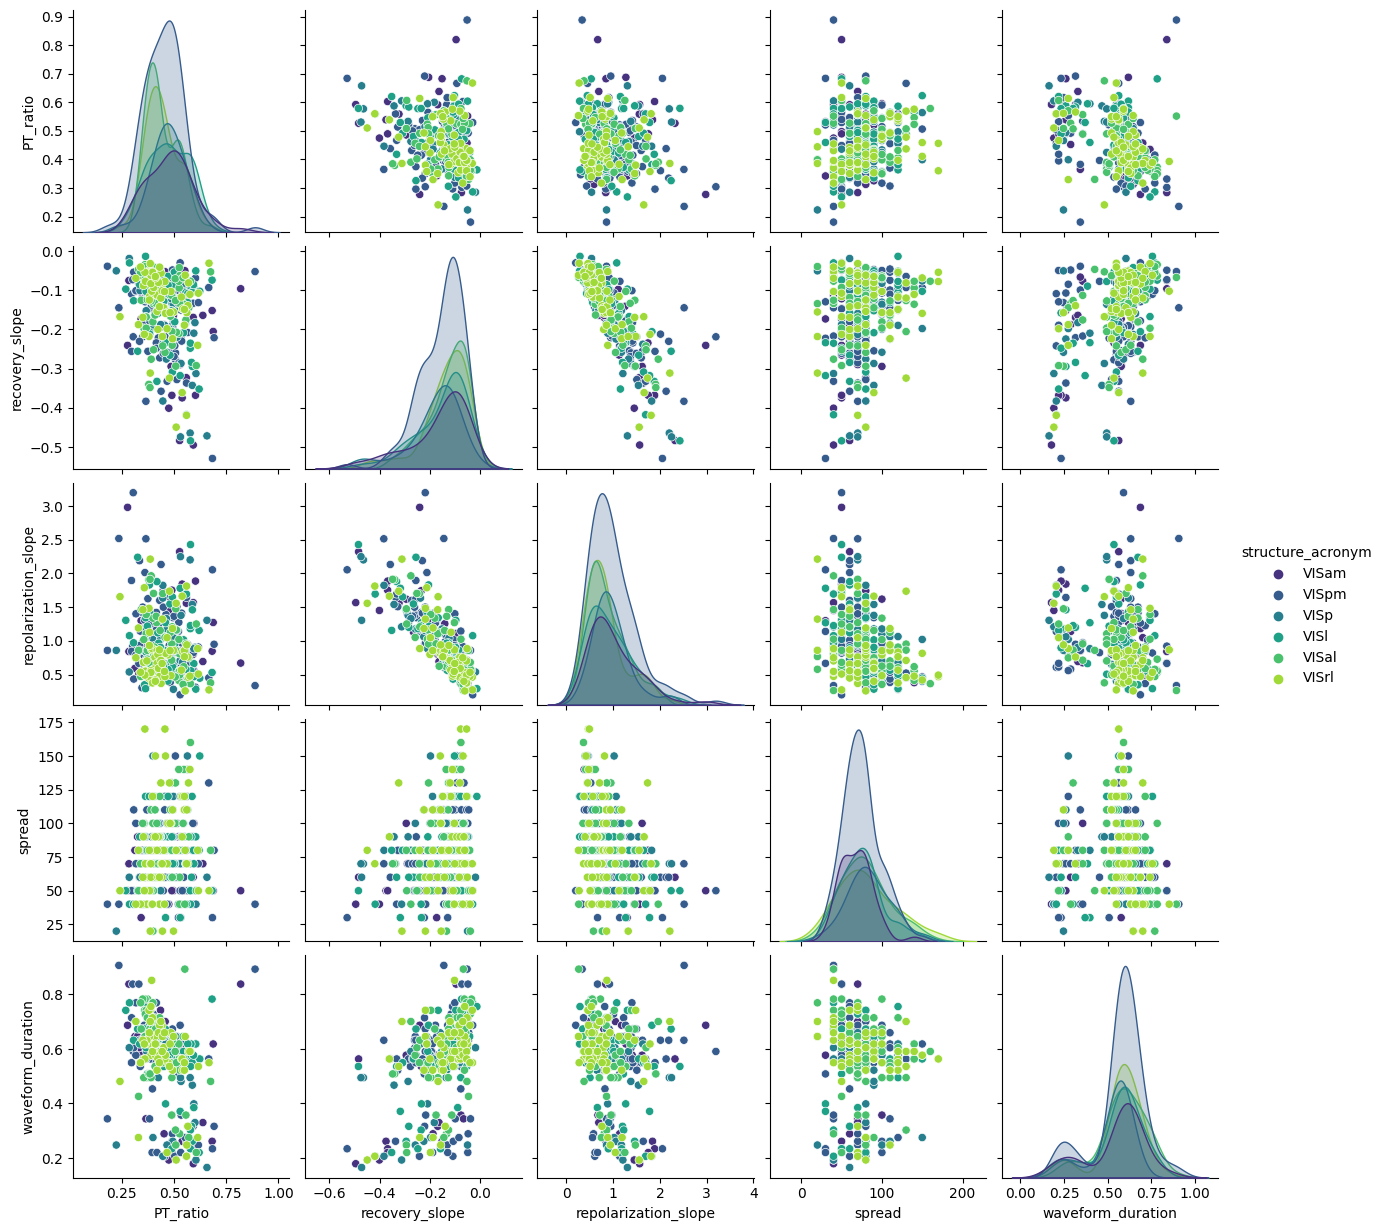

In [9]:
def plotUpVICellWaveformPropertiesByRegion(session_id):
    session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
    stimulus_presentations = session.stimulus_presentations
    units = session.get_units()
    channels = session.get_channels()
    units = units.merge(channels, left_on='peak_channel_id', right_index=True)
    good_V1_units = units[(units['structure_acronym'].str.contains('VI')) & 
                      (units['quality'] == 'good') & 
                      (units['isi_violations'] < 1) & 
                      (units['snr'] > 1)
                     ]
    features_to_study = good_V1_units[['PT_ratio','structure_acronym', 'recovery_slope', 'repolarization_slope', 'spread', 'waveform_duration']]
    features_to_study = features_to_study[features_to_study['PT_ratio']<1]
    features_to_study.dropna()
    #features = features_to_study.to_numpy()
    #kmeans = KMeans(n_clusters=3, random_state=0).fit(nrm(features, axis = 1))
    #features_to_study['labels'] = kmeans.labels_
    sns.pairplot(features_to_study, hue='structure_acronym', palette='viridis')

plotUpVICellWaveformPropertiesByRegion(1053941483)

In [ ]:
def plotUpVICellWaveformPropertiesBySST(session_id, SSTids):
    session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
    stimulus_presentations = session.stimulus_presentations
    units = session.get_units()
    channels = session.get_channels()
    units = units.merge(channels, left_on='peak_channel_id', right_index=True)
    good_V1_units = units[(units['structure_acronym'].str.contains('VI')) & 
                      (units['quality'] == 'good') & 
                      (units['isi_violations'] < 1) & 
                      (units['snr'] > 1)
                     ]
    features_to_study = good_V1_units[['PT_ratio','structure_acronym', 'recovery_slope', 'repolarization_slope', 'spread', 'waveform_duration']]
    features_to_study = features_to_study[features_to_study['PT_ratio']<1]
    features_to_study.dropna()
    #features = features_to_study.to_numpy()
    #kmeans = KMeans(n_clusters=3, random_state=0).fit(nrm(features, axis = 1))
    #features_to_study['labels'] = kmeans.labels_
    sns.pairplot(features_to_study, hue='structure_acronym', palette='viridis')

plotUpVICellWaveformPropertiesByRegion(1053941483)

## Extracting the SST cells from this optotagging

In [17]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    '''
    Convenience function to compute a peri-stimulus-time histogram
    (see section 7.2.2 here: https://neuronaldynamics.epfl.ch/online/Ch7.S2.html)
    INPUTS:
        spikes: spike times in seconds for one unit
        startTimes: trial start times in seconds; the first spike count 
            bin will be aligned to these times
        windowDur: trial duration in seconds
        binSize: size of spike count bins in seconds
    OUTPUTS:
        Tuple of (PSTH, bins), where:
            PSTH gives the trial-averaged spike rate for 
                each time bin aligned to the start times;
            bins are the bin edges as defined by numpy histogram
    '''
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for start in startTimes:
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins[:-1]


def make_neuron_time_trials_array(units, stim_table, 
                                   time_before, trial_duration, spike_times,
                                   bin_size=0.001):
    '''
    Function to make a 3D array with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_array: 3D array storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
        time_vector: vector storing the trial timestamps for the time bins
    '''
    # Get dimensions of output array
    neuron_number = len(units)
    trial_number = len(stim_table)
    num_time_bins = int(trial_duration/bin_size)
    
    # Initialize array
    unit_array = np.zeros((neuron_number, num_time_bins, trial_number))
    
    # Loop through units and trials and store spike counts for every time bin
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        
        # grab spike times for this unit
        unit_spike_times = spike_times[iu]
        
        # now loop through trials and make a PSTH for this unit for every trial
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            trial_start = trial.start_time - time_before
            unit_array[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    
    # Make the time vector that will label the time axis
    time_vector = np.arange(num_time_bins)*bin_size - time_before
    
    return unit_array, time_vector

In [21]:
def returnthe_putative_optotagged_SST(session_id):
    session = cache.get_ecephys_session(
                ecephys_session_id=session_id)
    opto_table = session.optotagging_table
    units = session.get_units()
    channels = session.get_channels()
    units = units.merge(channels, left_on='peak_channel_id', right_index=True)
    units = units.sort_values('probe_vertical_position', ascending=False)
    spike_times = session.spike_times

    #now we'll filter them for good units
    good_unit_filter = ((units['snr']>1)&             
                        (units['isi_violations']<1)& 
                        (units['firing_rate']>0.1)&   
                        (units['quality']=='good'))  

    area_filter = units['structure_acronym'].str.contains('VIS')
    cortical_units = units[good_unit_filter & area_filter]

    time_before_laser = 0.5
    trial_duration = 1.5
    bin_size = 0.001
    increase_in_FR = 5 #multiple increase over baseline rate
    min_evoked_rate = 50 #Hz

    time_array = np.arange(-time_before_laser,trial_duration-time_before_laser,bin_size)
    opto_array,time = make_neuron_time_trials_array(cortical_units, opto_table, time_before_laser, trial_duration, spike_times, bin_size)

    duration = opto_table.duration.min()
    level = opto_table.level.max()

    sel_trials=((opto_table['duration']==duration)&(opto_table['level']==level)).values

    #Average over these selected trials
    mean_opto_responses=np.nanmean(opto_array[:,:,sel_trials],2)

    # slice our data array to take the baseline period (before the laser turns on)
    baseline_time_idx = (time_array>=-0.010)&(time_array<-0.002)

    # then average over this time window in the mean_opto_responses to get the baseline rate for each unit
    baseline_rate = np.mean(mean_opto_responses[:,baseline_time_idx],1)

    evoked_rate_idx = (time_array>=0.001)&(time_array<0.009)
    evoked_rate = np.mean(mean_opto_responses[:,evoked_rate_idx],1)

    cre_pos_idx = (evoked_rate > min_evoked_rate) & ((evoked_rate / (baseline_rate + 1)) > increase_in_FR) 
    # add 1 to prevent divide-by-zero errors
    cre_pos_unit_ids = cortical_units[cre_pos_idx==True].index

    cre_pos_units = cortical_units.loc[cre_pos_unit_ids]
    return cre_pos_unit_ids

output = returnthe_putative_optotagged_SST(1053941483)

output[0]

C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


1061855316

C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!
placed one!


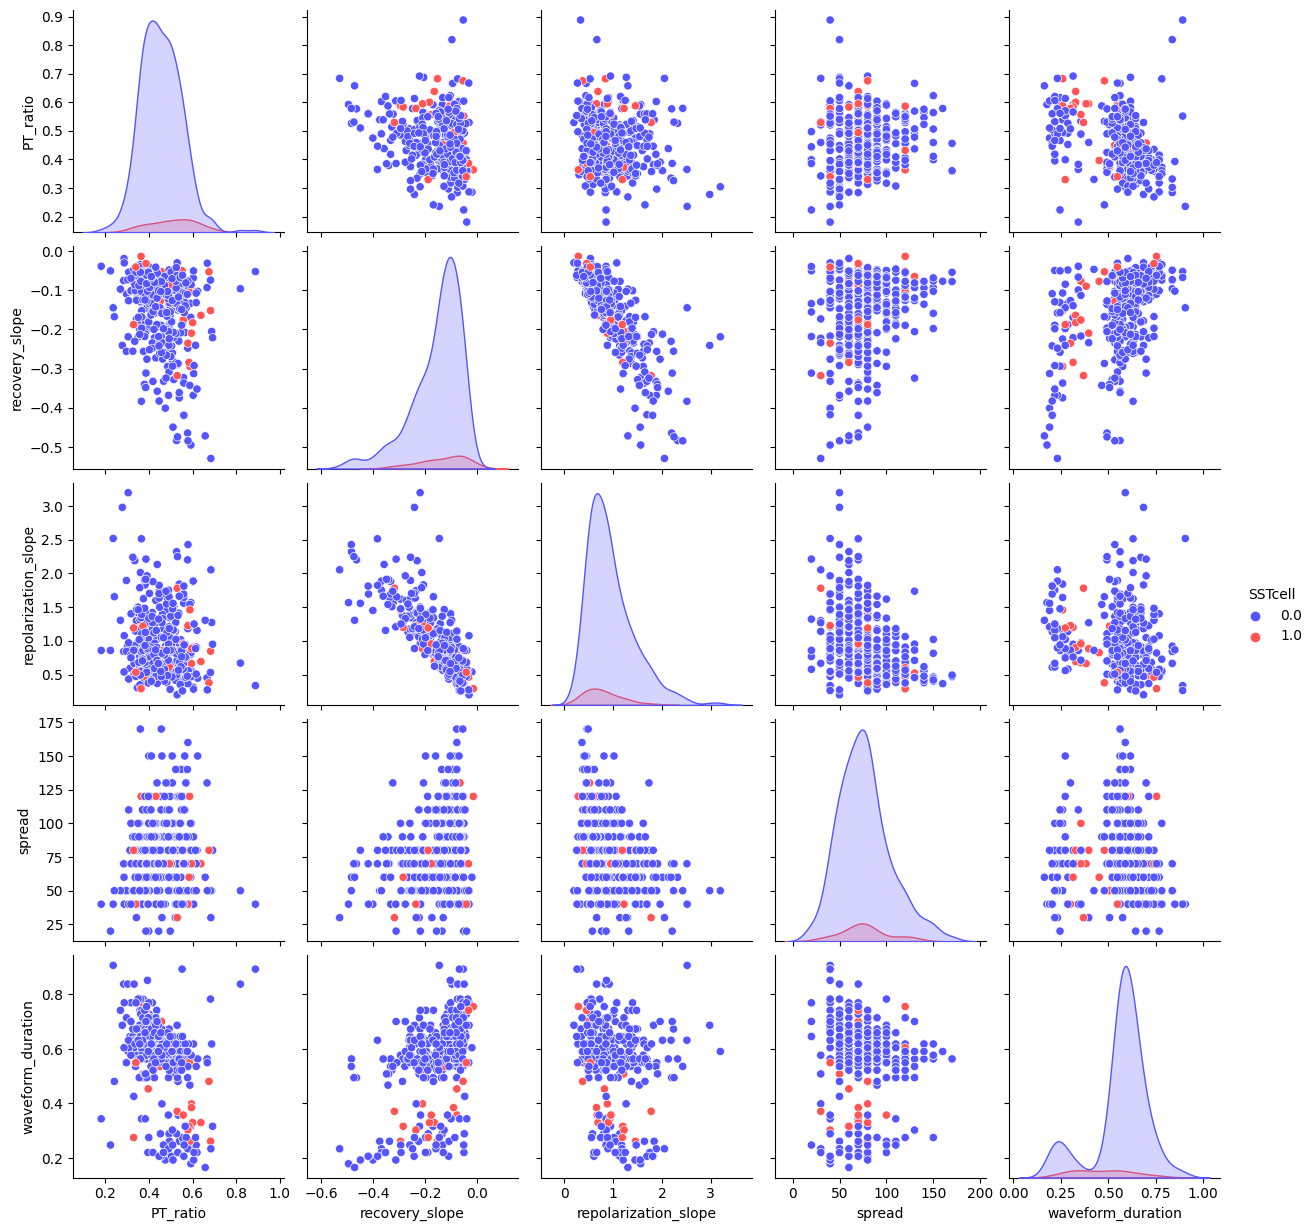

In [29]:
def plotUpVICellWaveformPropertiesBySST(session_id, SSTids):
    session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
    stimulus_presentations = session.stimulus_presentations
    units = session.get_units()
    channels = session.get_channels()
    units = units.merge(channels, left_on='peak_channel_id', right_index=True)
    good_V1_units = units[(units['structure_acronym'].str.contains('VI')) & 
                      (units['quality'] == 'good') & 
                      (units['isi_violations'] < 1) & 
                      (units['snr'] > 1)
                     ]
    features_to_study = good_V1_units[['PT_ratio', 'recovery_slope', 'repolarization_slope', 'spread', 'waveform_duration']]
    features_to_study = features_to_study[features_to_study['PT_ratio']<1]
    features_to_study.dropna()
    features_to_study['SSTcell'] = np.zeros([len(features_to_study),1])
    for i in range(len(features_to_study)):
        if features_to_study.index[i] in SSTids:
            features_to_study.loc[features_to_study.index[i]]['SSTcell'] = 1
            print('placed one!')
        else:
            features_to_study.loc[features_to_study.index[i]]['SSTcell'] = 0
    sns.pairplot(features_to_study, hue='SSTcell', palette='seismic')

plotUpVICellWaveformPropertiesBySST(1053941483, returnthe_putative_optotagged_SST(1053941483))

# This is extra code

In [10]:
session_id = 1053941483
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
stimulus_presentations = session.stimulus_presentations
units = session.get_units()
channels = session.get_channels()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)

C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [17]:
units.head(1)

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,waveform_duration,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,,,,,,,,,,,,,
1061853767,0.738222,632.394165,0.000008,23,79.63,10.843623,68.687706,0.000167,246.203332,3.104812e-08,...,0.20603,8254.0,3707.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6982.0,30,59,1054059289,320,APN


In [21]:
good_V1_units = units[(units['structure_acronym'].str.contains('VI')) & 
                      (units['quality'] == 'good') & 
                      (units['isi_violations'] < 1) & 
                      (units['snr'] > 1)
                     ]
good_V1_units.head(1)

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,waveform_duration,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,,,,,,,,,,,,,
1061853941,0.490965,207.99051,0.273518,196,347.89,3.966892,1.747814,0.37414,60.672055,0.003726,...,0.61809,7607.0,615.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,7642.0,294,59,1054059289,2960,VISam


In [78]:
features_to_study = good_V1_units[['PT_ratio', 'recovery_slope', 'repolarization_slope', 'spread', 'waveform_duration']]
features_to_study = features_to_study[features_to_study['PT_ratio']<1]
features_to_study.dropna()
features = features_to_study.to_numpy()
features
features_to_study

,PT_ratio,recovery_slope,repolarization_slope,spread,waveform_duration
id,,,,,
1061853941,0.490965,-0.112609,0.618665,70.0,0.618090
1061853945,0.457471,-0.052870,0.477453,70.0,0.700503
1061853900,0.819475,-0.096249,0.669639,50.0,0.837856
1061853930,0.312477,-0.059007,0.591308,80.0,0.645561
1061853917,0.538869,-0.374459,1.840844,50.0,0.260972
...,...,...,...,...,...
1061855334,0.561352,-0.157276,0.939657,110.0,0.247236
1061855270,0.442915,-0.101543,0.663516,70.0,0.590620
1061855280,0.538757,-0.361120,1.661722,90.0,0.563149


In [79]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize as nrm 
kmeans = KMeans(n_clusters=3, random_state=0).fit(nrm(features, axis = 1))
features_to_study['labels'] = kmeans.labels_

C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [76]:
features_to_study

,PT_ratio,recovery_slope,repolarization_slope,spread,waveform_duration,labels
id,,,,,,
1061853941,0.490965,-0.112609,0.618665,70.0,0.618090,2
1061853891,1.105938,-1.241809,1.728842,50.0,0.151089,1
1061853945,0.457471,-0.052870,0.477453,70.0,0.700503,2
1061853900,0.819475,-0.096249,0.669639,50.0,0.837856,1
1061853930,0.312477,-0.059007,0.591308,80.0,0.645561,2
...,...,...,...,...,...,...
1061855334,0.561352,-0.157276,0.939657,110.0,0.247236,2
1061855270,0.442915,-0.101543,0.663516,70.0,0.590620,2
1061855280,0.538757,-0.361120,1.661722,90.0,0.563149,1


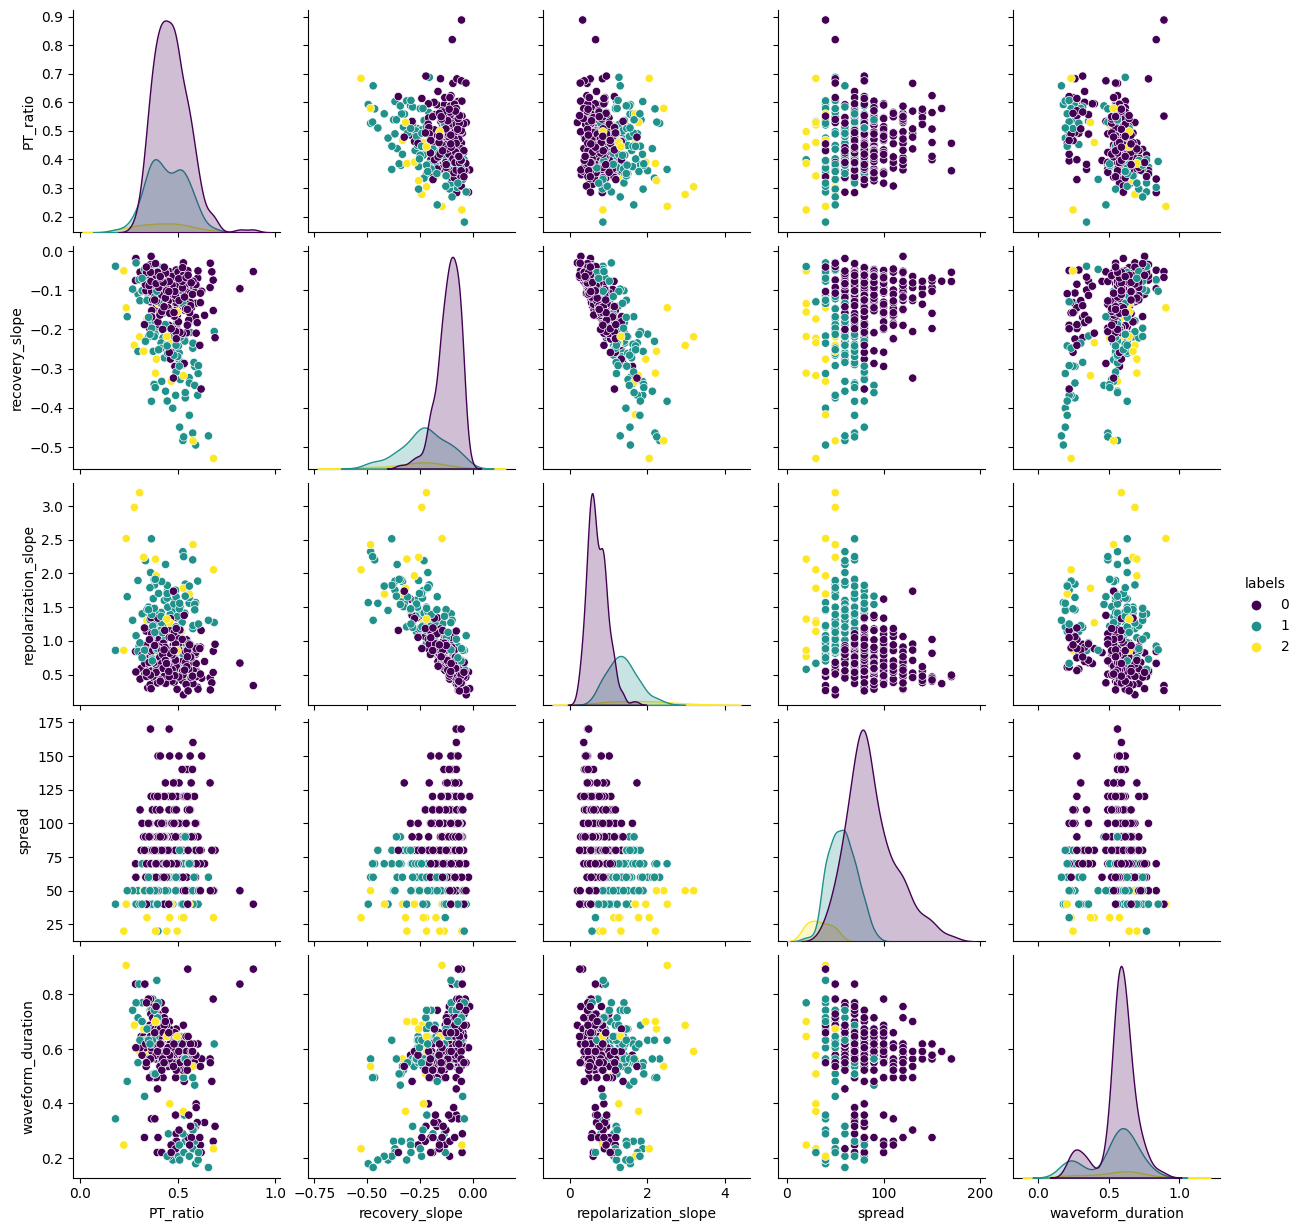

In [80]:
import seaborn as sns

sns.pairplot(features_to_study, hue='labels', palette='viridis')

C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\mstormbull\anaconda3\envs\swdb2022\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


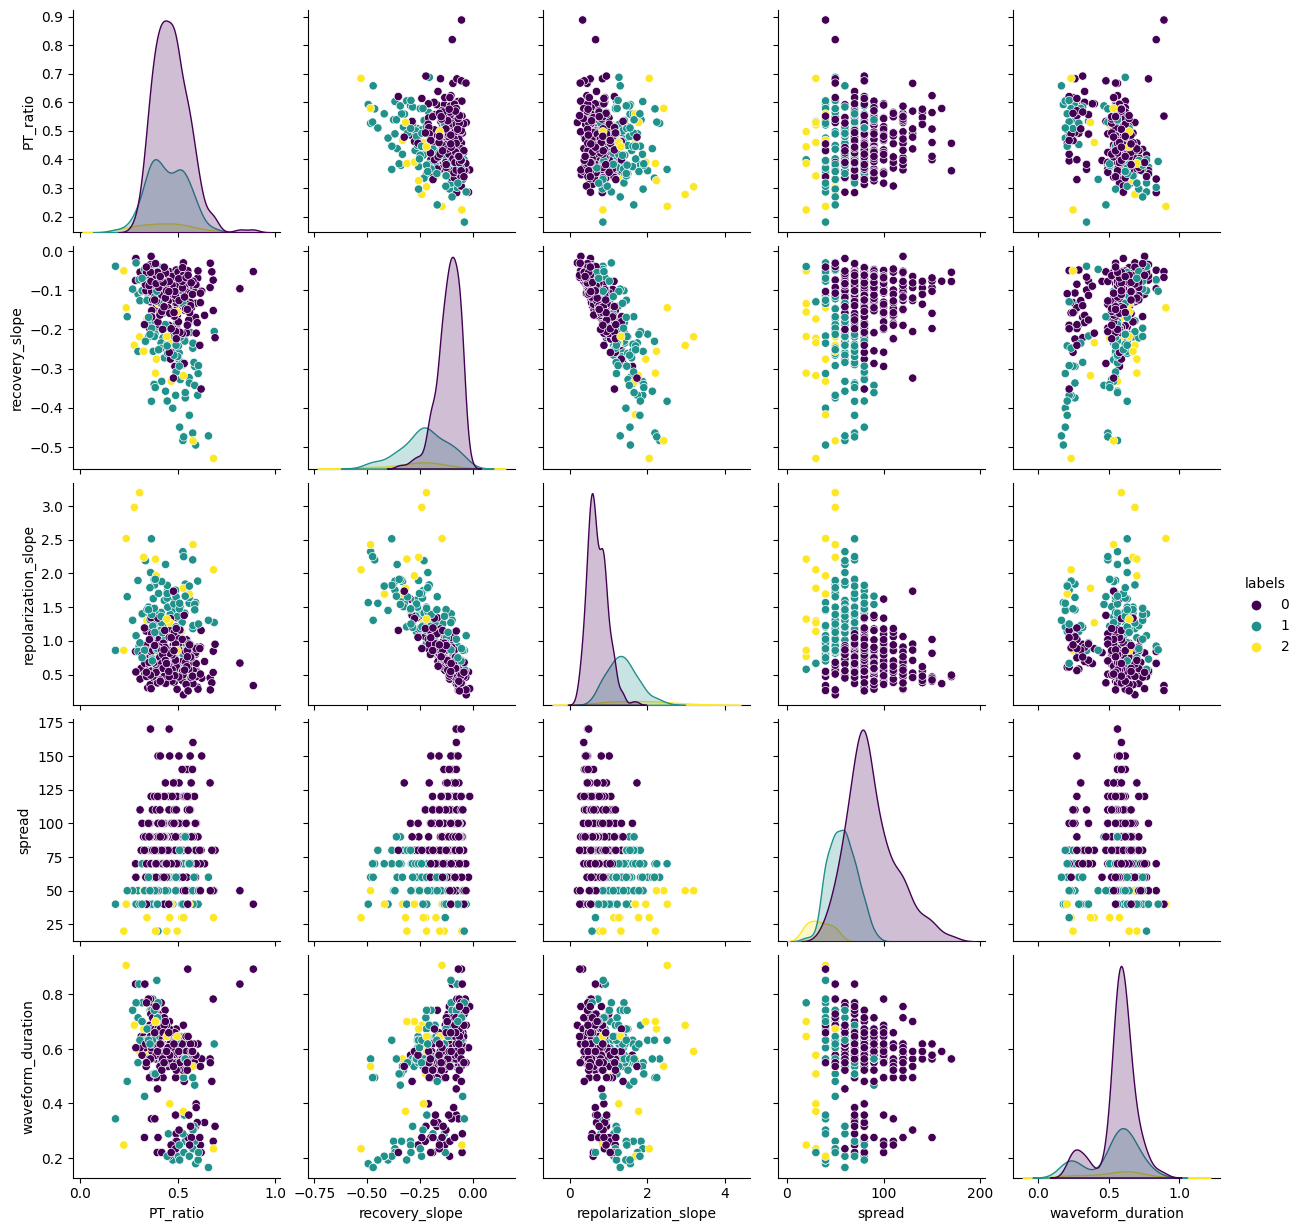

In [81]:
def plotUpVICellWaveformProperties(session_id):
    session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
    stimulus_presentations = session.stimulus_presentations
    units = session.get_units()
    channels = session.get_channels()
    units = units.merge(channels, left_on='peak_channel_id', right_index=True)
    good_V1_units = units[(units['structure_acronym'].str.contains('VI')) & 
                      (units['quality'] == 'good') & 
                      (units['isi_violations'] < 1) & 
                      (units['snr'] > 1)
                     ]
    features_to_study = good_V1_units[['PT_ratio', 'recovery_slope', 'repolarization_slope', 'spread', 'waveform_duration']]
    features_to_study = features_to_study[features_to_study['PT_ratio']<1]
    features_to_study.dropna()
    features = features_to_study.to_numpy()
    kmeans = KMeans(n_clusters=3, random_state=0).fit(nrm(features, axis = 1))
    features_to_study['labels'] = kmeans.labels_
    sns.pairplot(features_to_study, hue='labels', palette='viridis')

plotUpVICellWaveformProperties(session_id)